# Grupo 7: Regresión logística

In [1]:
# librerías
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import sys
import matplotlib.pyplot as plt
import pprint
from IPython.display import Image

In [ ]:
import func

## Introducción
Tomando como referencia el trabajo de investigación realizado por Colubri et al. (2019), se busca entrenar un modelo de regresión logística que permite pronosticar la supervivencia a enfermedad por virus del ébola.  Para tal propósito, se utilizan datos recolectados por el Cuerpo Internacionalde Medicina (IMC, por sus siglas en inglés) durante 2014 y 2016 en Liberia y Sierra Leona. 

<img src="img/region_aplicacion.png" alt="region_aplicacion" width="500"/>

>**Objetivo General:** Evaluar el desempeño de diferentes métodos de optimización numérica (método del máximo descenso, método de Newton, método BFGS(Broyden, Fletcher, Goldfarb y Shanno), y SGD), en un contexto de machine learning, utilizando métodos cómputo simples y en paralelo.

>>**Objetivo Particular:** En particular, se mide el desempeño, tanto en términos del uso y tiempo de recursos computacionales para lograr convergencia, como con relación a métricas de desempeño del modelo

**Nota:** Esta implementación se basa en material y actividades impartidas por los profesores de los cursos de [Métodos Numéricos y optimización](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/IV.optimizacion_convexa_y_machine_learning/4.3.Regresion_logistica_R.ipynb) (2010-I) (Prof. Erick Palacios Moreno) y Aprendizaje de Máquina (2019-II) (Prof. Rodrigo Mendoza Smith).


**Orden de Presentación**

> [1. Introducción al problema a resolver.](#section1)

> [2. Conjunto de Datos.](#section2)

> [3. Implementación de los métodos numéricos (demostración con Docker y AWS)](#section3)

> [4. Resultados obtenidos.](#section4)

## 1. Problema de regresión Logística

Como es resaltado por Murphy (2012), el problema de regresión logística es una generalización del problema de regresión lineal, convirtiendolo hacia un problema de clasificación, siempre y cuando la variable de respuesta sea de carácter binario (i.e. $y\in\left\{ 0,1\right\} $), y por tanto se pueda asumir que sigue una distribución Bernoulli. En este caso, dicha variable de respuesta corresponde a si el paciente muere a casua del virus del ébola $(1)$, o no $(0)$. 

Dado lo anterior, utilizamos:

$$
{Pr[y\mid\boldsymbol{x,w}]=Ber(y\mid\mu(x))}\label{eq:dist_ber}
$$

donde la media, se define en términos de la probabilidad de que el
paciente muera, es decir, $\mu(x)=E\left[y\mid x\right]=p\left(y=1\mid x\right)$.
Donde el conjunto de variables explicativas está representado por
$x$.

Por otro lado, para la realización del computo de la media, se utiliza
la función sigmoide, $\sigma(x)$, la cual garantiza que dada una
combinación lineal de las variables explicativas, con los parámetros
del modelo (i.e. $\beta^{T}x$), se cumpla que $0\leq\mu(x)\leq1$:

$$
\mu\left(x\right)=\sigma\left(\beta^{T}x\right)\label{eq:mu_x}
$$

donde $\sigma$ está definida por:

\begin{equation}
\sigma(x)=\frac{1}{1+\exp(-x)}=\frac{e^{x}}{e^{x}+1}\label{eq:sigmoide} 
\end{equation}

Los resultados asociados a la ecuación $\mu(x)$ están dados
en términos de probabilidades. Así, es necesario definir un umbral clasificatorio para definir si el modelo predice que el paciente fallezca, o no. En este ejercicio, como se hace usualmente, y como realizan Colubri et. al (2019), se toma como umbral el valor de $0.5$. Es decir:

<img src="img/umbral.png" alt="umbral" width="250"/>

Los parámetros asociados a las variables regresoras, $\hat{\beta}$, son estimados con el conjunto de datos de entrenamiento. 

### Función de pérdida

La función de pérdida asociada a este problema es la log-verosimilitud
negativa, o entropía cruzada, definida de las siguiente forma:


$$
LVN(\beta)=-\sum_{i=1}^{N}\left[y_{i}log\mu_{i}+(1-y_{i})log(1-\mu_{i})\right]\label{eq:lvn2}
$$

**Este problema no tiene solución analítica**. Es por esta razón que para minimizar
la función de pérdida en torno a $\beta$ es requerido **utilizar métodos de optimización numérica**. 


## 2. Conjunto de datos

Por la restricciones de uso de la base de datos de entrenamiento original (además de una serie de requerimientos protocolares como contar con la aprobación de un Comité de Ética Independiente), optamos por trabajar con una de las dos bases de datos que los autores emplearon para validar sus modelos: KGH. La base de datos en mención, consta de $106$ casos positivos  de  pacientes  con  ébola  y  un  case fatality rate global por encima del setenta por ciento.  Originalmente,  previo  al tratamiento de los datos, la base tenía únicamente $44$ registros de triaje, $58$ registros de carga viral, con un total de 78 valores faltantes en todo el data set. Para  harmonizar  los  datos,  los  autores  transformaron  la  carga  viral  en  CT,  conforme  con  la curva estándar qPCR:

$$log_{(carga \; viral)} = m*CT + c_0$$

Nosotros, para fines del presente trabajo, empleamos una de las versiones imputadas de esta base de datos, dispuesta en el siguiente sitio: [ebola-imc-public](https://github.com/dapivei/ebola-imc-public/blob/master/data/kenema/test/pres-kgh/imputation-50.csv), misma que cuenta con $11$ variables: la variable output, $y_{i}$ asociada a la supervivencia o no del paciente ${i}$ con virus del ébola, y ${j}$ variables explicativas asociadas, $x_{i,j}$. Los regresores escogidos son aquellos que, conforme con nuestra principal referencia, son buenos predictores de la probabilidad de muerte o no de un paciente. 

|Tipo| Nombre|Descripción|
|---| --- | --- |
|Variable Numérica| CT |El cycle threshold (CT) es una variable que se calcula a partir de una relación médica bien conocida (qPCR) y la carga viral (una expresión númerica de la cantidad de virus dado un volúmen de fluido que normalmente se correlaciona con la severidad de una infección viral activa).|
|Variable Numérica|TEMP|Temperatura corporal del paciente. Toma valores de $36$ a $39.9$.|
|Variable Numérica|_AGE_ |Edad del paciente. Toma valores de $1$ a $73$.|
|Variable Categórica |_HEADCH_ | Presencia o no dolores de cabeza. Toma valores valores $0$ o $1$, dependiendo de si el paciente presenta o no dolores de cabeza.|
|Variable Categórica |  _BLEED_ | Presencia o no de sangrado. Toma valores valores $0$ o $1$, dependiendo de si el paciente presenta o no sangrado. |
|Variable Categórica |  _DIARR_ | Presencia o no de diarrea. Toma valores valores $0$ o $1$, dependiendo de si el paciente presenta o no diarrea.|
|Variable Categórica | _VOMIT_ | Dificultad para comer, conocido como disfagia, término técnico para describir el síntoma consistente en dificultad para la deglución (problemaspara  tragar).   Esta  dificultad  suele  ir  acompañada  de  dolores,  a  veces lancinantes (disfagia dolorosa u odinofagia .  Toma valores valores $1$ o $0$, dependiendo de si el paciente presenta o no de disfacia
|Variable Categórica | _PABD*_ | Presencia o no de PADB.
|Variable Categórica |_WEAK_ | Presencia o no de debilidad o fatiga general.|
|Variable Categórica |_JAUN_ |Condición  en la cuál la piel, los ojos y los miembros mucosos que vuelven amarillos debido a altos niveles de bilirubina. Toma valores valores $0$ o $1$, dependiendo de si el paciente presenta o no ictericia.|
|Variable Categórica |_OUT_| Muerte o no muerte del paciente.  Toma valores $1$ o $0$.  Dependiendo desi el paciente muere o no muere.|


*: _PABD_ se refiere a Donación de sangre autóloga -personas en donde los trasplantes y las transfusiones la misma persona es a la vez donante y receptora- preoperatoria, Preoperative Autologous Blood Donation)



---------------------

## Importación y exploración del conjunto de datos

En esta sección se importa y transforma los datos, con el fin de obtener el conjunto $\mathcal{D}$.

In [41]:
url="https://raw.githubusercontent.com/afcarl/ebola-imc-public/master/data/kenema/test/pres-kgh/imputation-50.csv"
df_raw=pd.read_csv(url,sep=",")

In [42]:
df_raw.head()
# df[df.isnull().any(axis=1)] - no hay NAs

,OUT,CT,AGE,TEMP,HEADCH,BLEED,DIARR,JAUN,VOMIT,PABD,WEAK
0,1,28.652450,42.0,36.3,0,0,1,0,0,1,1
1,1,25.736016,45.0,36.5,1,0,1,0,0,1,1
2,1,20.747653,65.0,38.0,1,0,0,0,0,0,0
3,1,22.736993,44.0,38.6,1,0,0,0,0,0,1
4,1,20.846284,11.0,38.4,1,0,0,0,1,0,1


In [43]:
# verificar tipo de variables 
df_raw.dtypes

OUT         int64
CT        float64
AGE       float64
TEMP      float64
HEADCH      int64
BLEED       int64
DIARR       int64
JAUN        int64
VOMIT       int64
PABD        int64
WEAK        int64
dtype: object

In [44]:
# Resumen de las variables
df_raw.describe()

,OUT,CT,AGE,TEMP,HEADCH,BLEED,DIARR,JAUN,VOMIT,PABD,WEAK
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.0,106.000000,106.000000,106.000000
mean,0.764151,25.720411,34.102170,37.256604,0.603774,0.066038,0.405660,0.0,0.207547,0.273585,0.500000
std,0.426545,5.869164,17.382844,1.030767,0.491436,0.249528,0.493352,0.0,0.407477,0.447916,0.502375
min,0.000000,12.100000,0.830000,36.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,1.000000,22.149857,22.000000,36.300000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,1.000000,25.236301,35.500000,37.250000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.500000
75%,1.000000,28.680924,45.000000,38.225000,1.000000,0.000000,1.000000,0.0,0.000000,1.000000,1.000000
max,1.000000,39.799999,80.000000,39.900000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


In [45]:
df_raw_cat = df_raw.copy()

cat_vars = ['OUT', 'HEADCH', 'BLEED', 'DIARR', 'JAUN', 'VOMIT',
       'PABD', 'WEAK']
for var in cat_vars:
    df_raw_cat[var] = df_raw_cat[var].astype('category')
df_raw_cat.dtypes


OUT       category
CT         float64
AGE        float64
TEMP       float64
HEADCH    category
BLEED     category
DIARR     category
JAUN      category
VOMIT     category
PABD      category
WEAK      category
dtype: object

In [46]:
df_raw_cat.describe()

,CT,AGE,TEMP
count,106.000000,106.000000,106.000000
mean,25.720411,34.102170,37.256604
std,5.869164,17.382844,1.030767
min,12.100000,0.830000,36.000000
25%,22.149857,22.000000,36.300000
50%,25.236301,35.500000,37.250000
75%,28.680924,45.000000,38.225000
max,39.799999,80.000000,39.900000


In [47]:
# Describe categorical data
df_proc_cat = df_raw_cat.select_dtypes(include=['category']).copy()
df_proc_cat.describe()

,OUT,HEADCH,BLEED,DIARR,JAUN,VOMIT,PABD,WEAK
count,106,106,106,106,106,106,106,106
unique,2,2,2,2,1,2,2,2
top,1,1,0,0,0,0,0,1
freq,81,64,99,63,106,84,77,53


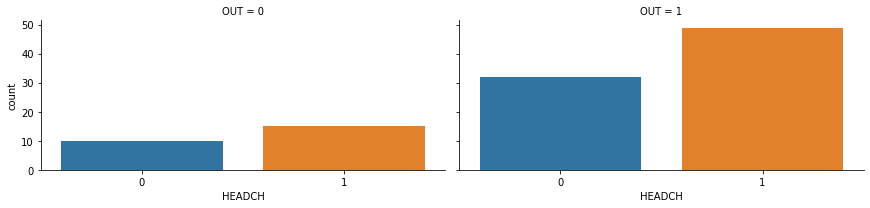

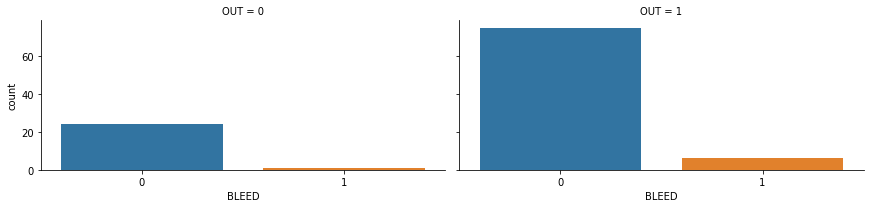

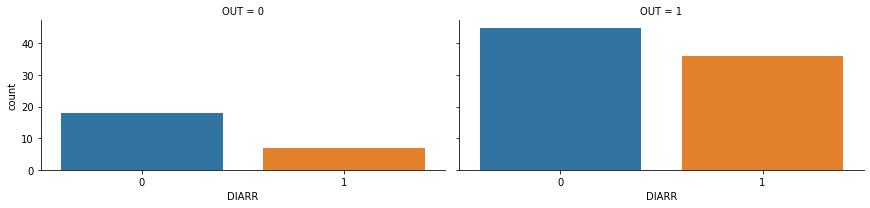

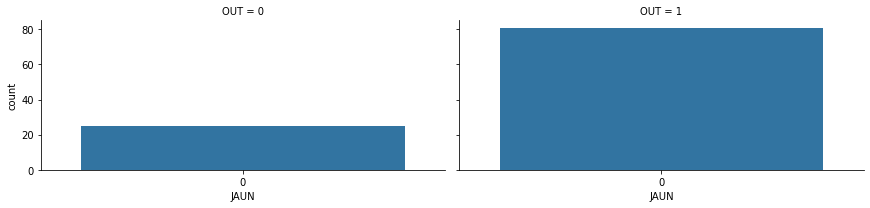

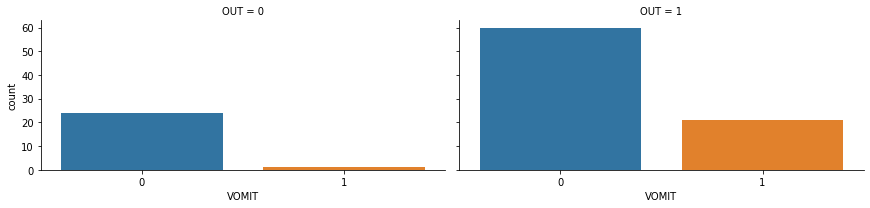

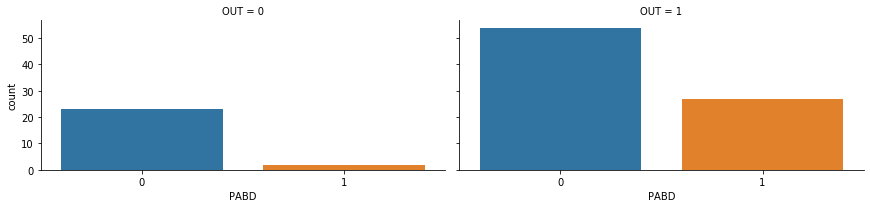

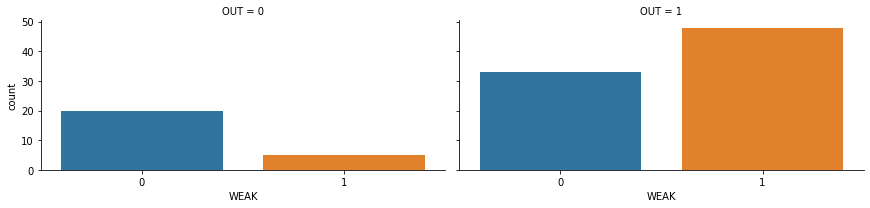

In [48]:
cat_vars = cat_vars[1:]

for i, col_val in enumerate(cat_vars):
    sns.catplot(x = col_val, y = None, hue= None, col="OUT",
                data=df_proc_cat, kind="count",
                height=3, aspect=2);


**Algunas observaciones sobre los datos**

- El case fatality rate (OUT) de nuestra base de datos se sitúa en 76 por ciento. Es decir, del total de pacientes con ébola, 81 murieron.

- Para este conjunto de datos la variable `JAUN` no tiene variabilidad, por lo tanto no es una variable, y se omite.


Dado lo anterior, se ajusta el set de datos:

- Se crean 3 grupos de edades, utilizando el percetil 25 (22 años), percentil 50 (36 años) y percentil 75 (45 años).

- Se elimina la columna `JAUN`.

## Transformaciones al conjunto de datos

In [49]:
# ajustes en df_raw 
df_proc = df_raw
df_proc['INTER_AGE'] = "NA"

df_proc.dtypes

OUT            int64
CT           float64
AGE          float64
TEMP         float64
HEADCH         int64
BLEED          int64
DIARR          int64
JAUN           int64
VOMIT          int64
PABD           int64
WEAK           int64
INTER_AGE     object
dtype: object

In [50]:
# ajustes en df_raw 
df_proc = df_raw

# para la variable edad se crean cuatro categorías
age_p25 = math.ceil(df_proc['AGE'].quantile(.25))
age_p50 = math.ceil(df_proc['AGE'].quantile(.50))
age_p75 = math.ceil(df_proc['AGE'].quantile(.75))

df_proc['INTER_AGE'] = "NA"
df_proc.loc[(df_proc['AGE'] <= age_p25), 'INTER_AGE'] = 1
df_proc.loc[(df_proc['AGE'] > age_p25) & (df_proc['AGE'] <= age_p50), 'INTER_AGE'] = 2
df_proc.loc[(df_proc['AGE'] > age_p50) & (df_proc['AGE'] <= age_p75), 'INTER_AGE'] = 3
df_proc.loc[(df_proc['AGE'] > age_p75), 'INTER_AGE'] = 4

## one hot encoding
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(df_proc[['INTER_AGE']]).toarray())
enc_df = enc_df.rename(columns={0: f"hasta{age_p25}", 1: f"entre{age_p25+1}y{age_p50}", 2: f"entre{age_p50+1}y{age_p75}", 3:f"mayor{age_p75}"})
# merge with main df bridge_df on key values
df_proc = df_proc.join(enc_df)
    
# se omiten las variables JAUN, AGE, INTER_AGE
del_vars = ["JAUN", "AGE", "INTER_AGE"]
for var in del_vars:
    df_proc = df_proc.drop(var, axis=1)    
    
# se comprueban los tipos de variable
df_proc.dtypes

OUT             int64
CT            float64
TEMP          float64
HEADCH          int64
BLEED           int64
DIARR           int64
VOMIT           int64
PABD            int64
WEAK            int64
hasta22       float64
entre23y36    float64
entre37y45    float64
mayor45       float64
dtype: object

In [51]:
df_proc

,OUT,CT,TEMP,HEADCH,BLEED,DIARR,VOMIT,PABD,WEAK,hasta22,entre23y36,entre37y45,mayor45
0,1,28.652450,36.3,0,0,1,0,1,1,0.0,0.0,1.0,0.0
1,1,25.736016,36.5,1,0,1,0,1,1,0.0,0.0,1.0,0.0
2,1,20.747653,38.0,1,0,0,0,0,0,0.0,0.0,0.0,1.0
3,1,22.736993,38.6,1,0,0,0,0,1,0.0,0.0,1.0,0.0
4,1,20.846284,38.4,1,0,0,1,0,1,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,1,24.191797,36.4,0,0,1,1,1,1,0.0,0.0,1.0,0.0
102,1,20.846284,38.4,0,0,0,1,0,1,0.0,1.0,0.0,0.0
103,0,38.816561,36.0,0,0,0,0,0,0,1.0,0.0,0.0,0.0
104,1,21.960294,36.4,0,0,0,0,0,0,0.0,1.0,0.0,0.0


## Planteamiento del problema de regresión

Para los algoritmos a utilizar, es imprecindible la utilización del gradiente y la matriz hessiana asoaciados a $LVN(\beta)$, los cuales se definen a continuación:

$$
\nabla LVN=\frac{d}{d\boldsymbol{\beta}}f(\boldsymbol{\beta})=\sum_{i}(\mu_{i}-y_{i})x_{i}=X^{T}(\mu-y)\label{eq:gradiente}
$$

$$
\nabla^{2}LVN=\frac{d}{d\boldsymbol{\beta}}g(\boldsymbol{\beta})^{T}=\sum\left(\nabla_{\beta}\mu_{i}\right)x_{i}^{T}=\sum\mu_{i}(1-\mu_{i})x_{i}x_{i}^{T}=\boldsymbol{X}^{T}\boldsymbol{S}\boldsymbol{X}\label{eq:hessiana}
$$

donde $\boldsymbol{S}\triangleq diag(\mu_{i}(1-\mu_{i}))$. Adicionalmente, como resalta Murphy (2012), dado que $\boldsymbol{H}$ es positiva definida, entonces $LVN(\beta)$ tiene un mínimo global que puede ser alcanzable utilizando métodos de optimización.

### Métodos de búsqueda de línea

En los métodos de búsqueda de línea son métodos iterativos que consisten en dar pasos sobre una dirección de descenso para una función convexa. En cada iteración damos una paso de la forma:

$$x_{k+1}=x_k +\alpha_k p_k$$

donde $\alpha$ representa el tamaño del paso y $p_k$ la dirección del descenso.

La dirección de descenso la definimos como:

$$p_k=-B^{-1}_k \nabla f_k$$

Con $B$ una matriz simétrica y no singular.

Cuando $B_k$ es definida postiva entonces tenemos que:

$$p^T_k \nabla f_k = -\nabla f^T_k B^{-1}_k \nabla f_k$$

y por tanto $p_k$ es una dirección de descenso.

### Condiciones de Armijo

$$
f\left(x_{k}+\alpha p_{k}\right)\leq f(x_{k})+c_{1}\alpha\nabla f_{k}^{T}p_{k}
$$

### Método de máximo descenso

$$B_k = I$$

### Método de Newton

$$B_k = \nabla^2 f_k$$

### BFGS


$$B^{-1}_k \approx H_k$$

In [53]:
def descent_direction(X, y, beta, method="max",H=None):
    '''
    Función que devuelve vector normalizado (px1) que apunta en la direccion de decenso
        ** Parámetros:
            - X (mat): matriz de mxp entradas
            - y (vec): vector de de m entradas de la variable output
            - beta (vec float64): vector de entradas a optimizar
            - method (str): método que determina la dirección de descenso
    
                    --Opciones:
                            --- max: método de descenso
                            --- newton: método de Newton
                            --- bfsg: metodo bfsg
            - H (mat pxp): Parámetro para la dirección de decenso del metodo bfgs
    
        ** Salidas
            - pk (vec): vector normalizado con la direccion del paso
    '''
    if(method == "max"):
        pk = gradiente_f(X,y,beta)
    
    elif(method == "newton"):
        grad = gradiente_f(X,y,beta)
        hess = hessiana_f(X,y,beta)
        pk = np.linalg.solve(hess,grad)
        
    elif(method=="bfsg"):
        # Se revisa que los parámetros de entrada sean congruentes con la funcionalidad
        if type(H) is not np.ndarray:
            sys.exit('Error: H debe ser de tipo numpy.ndarray')
        pk = np.matmul(H,gradiente_f(X,y,beta))
                              
    return - normalize(pk)


In [55]:
def calc_lr(X, y, beta, lr, pk, c1=10**(-4), tao=0.5, reset_lr=False):
    '''
    Función que calcula el tamaño del paso para cada iteración utilizando la condicion de armijo.
    La tasa de aprendizaje minima es la que tenia en el paso anterior.
    
        ** Parámetros:
        
            - X (mat): matriz de mxp entradas
            - y (vec): vector de de m entradas de la variable output
            - lr (float64): tasa de aprendizaje
            - pk (array px1 float64): direccion de decenso
            - c1 (float64) 0<c1<1: parametro de control
            - tao (float64) 0<tao<1: parametro de decrecimiento de lr
            
        ** Salidas
        
            - lr (float64): tamaño de paso
    '''
    # Se revisa que los parámetros de entrada sean congruentes con la funcionalidad    
    if tao > 1 or tao < 0:
        sys.exit('Error:  tao es un parámetro que debe estar entre 0 y 1')  
    if c1 > 1 or c1 < 0:
        sys.exit('Error:  c1 es un paramétro que debe estar entre 0 y 1') 

    # Inicializamos 
    tao = 0.9
    max_iter = 100
    iter = 0
    
    # Inicializa lr
    if reset_lr==True: lr = 1

    # Evaluaciones periódicas
    grad = gradiente_f(X,y,beta)
    eval_f = f(X,y, beta)
    
    # Primera iteracion
    f_x =  f(X,y, beta + lr*pk) #en nocedal es phi(alpha)
    f_x1 = eval_f + c1 * lr *  np.dot(grad,pk) # en nocedal es l(alhpa)
    
    while ((f_x > f_x1) & (iter < max_iter)):
        lr = lr*tao
        f_x =  f(X,y, beta + lr*pk) 
        f_x1 = eval_f + c1 * lr *  np.dot(grad,pk) 
        iter+=1
    
    return lr

In [57]:
def gradient_descent(X, y, lr=1, tol=10**(-7), max_iter=10**5, method="max", reset_lr=False, verbose_n=1000):
    '''
    Función que devuelve vector de parámetros beta (px1) resultante del proceso
    de optimización por descenso de gradiente
    
        ** Parámetros:
            - X (mat): matriz de mxp entradas
            - y (vec): vector de de m entradas de la variable output
            - lr (float64): valor inicial de la tasa de aprendizaje
            - tol (float64): criterio de convergencia
            - max_iter (int): número máximo de iteraciones
            - method (str): método que determina la dirección de descenso
                Opciones:
                    -- max: método de descenso
                    -- newton: método de Newton
                    -- bfsg
        ** Salidas
            - beta_new (vec): vector de p entradas con parámetros que minimizan la función de pérdida
    '''
    # imprime método
    out.write(BOLD + "="*65)
    if (method=="max"):
        out.write(BOLD + 'Método de máximo descenso')
    elif (method=="newton"):
        out.write(BOLD + 'Método de Newton')
    elif (method=="bfsg"):
        out.write(BOLD + 'Método de BFGS')
    out.write(BOLD + "="*65)
    
    # Se revisa que los parámetros de entrada sean congruentes con la funcionalidad
    m,p = X.shape
    if y.shape[0]!= m:
        sys.exit('Error:  El número de renglones de X debe ser igual al número de entradas del vector y.')

    
    # Inicializa
    iteraciones=0
    H = None
    dims = X.shape[1]
    tol = tol*dims
    
    # Inicializamos beta aleatoria
    beta = np.random.normal(1,3,dims)
    if method =="bfsg": H = np.identity(dims)
    
    # Primera iteracion
    pk =  descent_direction(X, y, beta, method,H)
    beta_new = beta + lr*pk
    if method == "bfsg": H=calc_H(X,y,beta,beta_new,H) 
    
    # Condición de paro.
    while ((np.linalg.norm(gradiente_f(X,y,beta_new)) > tol) & (iteraciones < max_iter)):
        iteraciones+=1 #contador de ciclo
        
        beta = beta_new
        pk =  descent_direction(X,y,beta,method,H)
        lr = calc_lr(X, y, beta, lr, pk, reset_lr = reset_lr)
        
        beta_new = beta + lr*pk
        
        if method == "bfsg": H=calc_H(X,y,beta,beta_new,H)
            
        # Imprime

        if iteraciones % verbose_n == 0:
            grad=np.linalg.norm(gradiente_f(X,y,beta_new))
            out.write(UNDERSCORE + f'Iteración: {iteraciones}' + ALL_OFF + f' gradiente: {grad:.7E}, alpha: {lr:.4E}')            

    print("\n") 
    out.write(BOLD  + '** Resultados Finales')
    if iteraciones == max_iter:out.write(BOLD + 'El algoritmo paro porque' + BOLD + FG_RED + 'se alcanzo el nro. máximo de iteraciones.')
    out.write(BOLD + f'* Total de iteraciones: ' +ALL_OFF+ f'{iteraciones}'  )
    out.write(BOLD + f'* Norma del gradiente de f: ' +ALL_OFF+ f'{np.linalg.norm(gradiente_f(X,y,beta_new))}' )
    out.write(BOLD + f'* beta_hat:' )
    pprint.pprint(beta_new)
    print("\n") 
    
    return beta_new

## Split and Train

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
np.random.seed(3338014)
    
data =df_proc.to_numpy()
y = data[:,0]
X = data[:,1:]
x_train, x_test, y_train, y_test=train_test_split(X,y,test_size=.2)

# Scale data
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [59]:
%%time 
np.random.seed(3338014) # para replicabilidad
beta_hat = gradient_descent(x_train,y_train,max_iter=10**6,reset_lr=False,verbose_n=500)
yhat = clasifica(x_test,beta_hat)

out.write(BOLD + f'* Error de clasificación: ' + ALL_OFF + f'{round(100*sum(abs(y_test-yhat))/len(yhat),2)}%' )
out.write(BOLD + "="*65)

Método de máximo descenso
Iteración: 500 gradiente: 2.5045446E-01, alpha: 7.1790E-02
Iteración: 1000 gradiente: 1.9681746E-02, alpha: 5.7264E-03
Iteración: 1500 gradiente: 3.6459555E-03, alpha: 1.0611E-03
Iteración: 2000 gradiente: 4.4262414E-04, alpha: 1.2901E-04
Iteración: 2500 gradiente: 2.3181024E-05, alpha: 6.7516E-06


** Resultados Finales
* Total de iteraciones: 2964
* Norma del gradiente de f: 9.756061172576794e-07
* beta_hat:
array([-10.36242902,  16.25102342,  -3.90446862,   0.60600272,
         0.77744891,   4.55476501,  -0.91897329,   3.3866912 ,
         3.76095218,   3.9617985 ,   4.98358393,   6.21113331])


* Error de clasificación: 4.55%
CPU times: user 650 ms, sys: 47.8 ms, total: 697 ms
Wall time: 660 ms


In [60]:
%%time
# Método de Newton
np.random.seed(3338014) # para replicabilidad
beta_hat = gradient_descent(x_train,y_train, method="newton",max_iter = 10**5,verbose_n = 20)
yhat = clasifica(x_test,beta_hat)

out.write(BOLD + f'* Error de clasificación: ' + ALL_OFF + f'{round(100*sum(abs(y_test-yhat))/len(yhat),2)}%' )
out.write(BOLD + "="*65)

Método de Newton
Iteración: 20 gradiente: 4.3186382E-01, alpha: 1.0000E+00
Iteración: 40 gradiente: 6.6389532E-04, alpha: 7.0697E-03
Iteración: 60 gradiente: 5.1340283E-05, alpha: 5.6392E-04
Iteración: 80 gradiente: 2.6953093E-06, alpha: 2.9513E-05


** Resultados Finales
* Total de iteraciones: 87
* Norma del gradiente de f: 1.1609129137769218e-06
* beta_hat:
array([-10.36243506,  16.25103288,  -3.90446995,   0.60600623,
         0.77744971,   4.55476817,  -0.91897444,   3.3866927 ,
         3.76095382,   3.96180007,   4.98358595,   6.21113592])


* Error de clasificación: 4.55%
CPU times: user 177 ms, sys: 16.6 ms, total: 194 ms
Wall time: 71.7 ms


In [61]:
%%time
# Método BFSG
np.random.seed(333814) # para replicabilidad
beta_hat = gradient_descent(x_train,y_train, method = "bfsg",max_iter = 10**6,lr=1,verbose_n = 10000)
yhat = clasifica(x_test,beta_hat)

out.write(BOLD + f'* Error de clasificación: ' + ALL_OFF + f'{round(100*sum(abs(y_test-yhat))/len(yhat),2)}%' )
out.write(BOLD + "="*65)

Método de BFGS
Iteración: 10000 gradiente: 7.0627661E-02, alpha: 2.0276E-02
Iteración: 20000 gradiente: 3.6716352E-03, alpha: 1.0611E-03
Iteración: 30000 gradiente: 1.9548109E-04, alpha: 5.5533E-05
Iteración: 40000 gradiente: 2.3716148E-05, alpha: 6.7516E-06


** Resultados Finales
* Total de iteraciones: 47837
* Norma del gradiente de f: 1.1624129428409921e-06
* beta_hat:
array([-10.36240975,  16.25097655,  -3.90446056,   0.60599614,
         0.77744804,   4.55475336,  -0.91896656,   3.38668298,
         3.76094818,   3.96179347,   4.98357503,   6.21112378])


* Error de clasificación: 4.55%
CPU times: user 16.6 s, sys: 810 ms, total: 17.4 s
Wall time: 19 s


## Descenso del gradiente estocastico

Calculamos la función de riesgo empírico como la esperanza de la funcion de perdida evaluada sobre todos los puntos del dominio.

$$L_{emp}=\frac{1}{m} \sum^{m}_{i=1} y_i log(\mu_i) + (1-y_i) log(1-\mu_i)$$  
<br>
$$ \mu_i = (1+e^{-\beta^T x_i})^{-1}= \sigma(\beta^T x_i)$$

Y el gradiente de la función de riesgo esta dado por:

$$\nabla L=\frac{dL}{d\mu_i} =\frac{1}{m} \sum^{m}_{i=1} x_i(\mu_i-y_i)$$

In [64]:
def SGD(X,y,batch_size,verbose_n=100,max_iter=10**5):

     # Se revisa que los parámetros de entrada sean congruentes con la funcionalidad
    m,p = X.shape
    if y.shape[0]!= m:
        sys.exit('Error:  El número de renglones de X debe ser igual al número de entradas del vector y.')


    # Inicializa
    m=X.shape[0]
    epsilon = 10**(-6)
    beta = np.random.normal(0,1,X.shape[1])    
    step_size=.01
    iteraciones = 0
    epoca=0
    ipe=int(m/batch_size)#iteraciones por epoca
    
    # Primera iteracion
    index=batch(m,batch_size)
    x_lote=X[index,:]
    y_lote = y[index]
    beta_new = beta - step_size * gradiente_riesgo_empirico(x_lote,y_lote,beta) 
    

    perdida=riesgo_empirico(X,y,beta)
    error=error_train(X,y,beta)
    
    while iteraciones<max_iter:
        iteraciones +=1
        beta = beta_new
        index=batch(m,batch_size)
        x_lote=X[index,:]
        y_lote = y[index]
        beta_new = beta - step_size * gradiente_riesgo_empirico(x_lote,y_lote,beta)
        #print("iteraciones2=",iteraciones)
        if iteraciones%10000==0:
            epoca+=1
            loss=riesgo_empirico(X,y,beta)
            perdida=np.append(perdida,loss)
            err=error_train(X,y,beta)
            error=np.append(error, error_train(x_test,y_test,beta_hat))
            print(f'loss:{loss:.4}, epoca:{epoca}, iter:{iteraciones}')
    print("Nº DE INTERACIONES: ",iteraciones)
    return beta_new,perdida,error

*========================================================================*
Tamaño de minilote=  9
loss:24.65, epoca:1, iter:10000
loss:19.97, epoca:2, iter:20000
loss:17.92, epoca:3, iter:30000
loss:16.75, epoca:4, iter:40000
loss:15.98, epoca:5, iter:50000
loss:15.43, epoca:6, iter:60000
loss:15.02, epoca:7, iter:70000
loss:14.69, epoca:8, iter:80000
loss:14.42, epoca:9, iter:90000
loss:14.21, epoca:10, iter:100000
Nº DE INTERACIONES:  100000


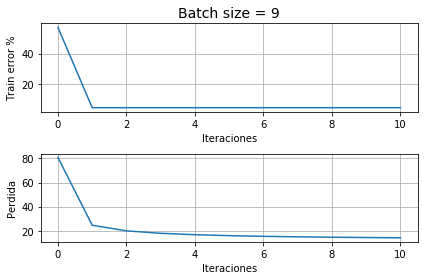

beta_hat= [-5.51625653  9.41234684 -2.34521111 -0.25427645  0.59709283  2.51511279
 -0.01347701  2.10364421  2.07589005  1.96217798  2.23616146  3.42584893]
Error de clasificacion= 9.09 %


CPU times: user 9.07 s, sys: 482 ms, total: 9.56 s
Wall time: 10.7 s


In [66]:
%%time
np.random.seed(3338014) # para replicabilidad
# Método de SGD
for batch_size in range(9,10):
    
    
    print("*========================================================================*")
    print("Tamaño de minilote= ",batch_size)
    beta_hat, loss, error = SGD(x_train, y_train, max_iter=10**5, batch_size=batch_size)
    yhat = clasifica(x_test,beta_hat)
    titulo="Batch size = "+ str(batch_size)
    graf_loss_err(loss,error,titulo)
    print("beta_hat=", beta_hat)
    print("Error de clasificacion=",round(100*sum(abs(y_test-yhat))/len(yhat),2),"%")
    print("\n")

In [ ]:
import multiprocessing
import time
from dask.distributed import Client, progress
client = Client()

In [69]:
client

Client Scheduler: tcp://127.0.0.1:59415 Dashboard: http://127.0.0.1:59416/status,Cluster Workers: 4 Cores: 8 Memory: 8.59 GB


In [70]:
# paso 1. Dividir el dominio en partes iguales
cores = multiprocessing.cpu_count() # cpus disponibles
#n_subint = int(density_p/p) # número de puntos o nodos en cada core o cpu

In [71]:
def construye_indices(ids,m,cores):
    '''
    Argumentos:
    ----------
    * ids: Identificador del core dónde se está corriendo el task. 
    * m (array): Numero total de puntos de entrenamiento.
    * cores (int) : Número de cores o cpus disponibles
    
    Salidas:
    -------
    * (index_from, index_to): Rango de indices que se seleccionan del verctor de permutaciones
    '''
    
    tamano_int = int(m/cores) #tamaño de cada sub intervalo.
    index_from = ids*tamano_int #construyen los subintervalo
    index_to = index_from + tamano_int
    if ids==(cores-1): index_to=m
    return (index_from,index_to)


def evalua_gradiente(intervalo,perm,X,y,beta):
    """
    Función que evalúa el gradiente del riesgo empirico para cada conjunto de indices de permutaciones    
    Argumentos:
    ----------
    * intervalo: Intervalo de indices del vector perm a utilizar
    * perm: Vector de permutaciones 
    * X: Puntos de entrenamiento
    * y: Etiquetas de los puntos de entrenamiento
    * beta: Vector de parametros a optimizar
    
    Salidas:
    * Evaluacion del gradiente del riesgo empirico para un mini lote
    --------

    """   
    index=perm[intervalo[0]:intervalo[1]]
    x_lote = X[index,:]
    y_lote = y[index]
    gradiente=gradiente_riesgo_empirico(x_lote,y_lote,beta) 
    return gradiente


In [72]:
def SGD_paralelo(X,y,verbose_n=100,max_iter=10**5):

     # Se revisa que los parámetros de entrada sean congruentes con la funcionalidad
    m,p = X.shape
    if y.shape[0]!= m:
        sys.exit('Error:  El número de renglones de X debe ser igual al número de entradas del vector y.')

    
    # Inicializa
    m=X.shape[0]
    epsilon = 10**(-6)
    beta = np.random.normal(0,1,X.shape[1])    
    step_size=.01
    iteraciones = 0
    epoca=0
    
    # Primera iteracion
    perm=n_batch(m)
    #calcula los indices
    indices = client.map(construye_indices,range(cores),
                **{'m':m,'cores':cores})

    #evalua el gradiente en cada batch en paralelo
    grad_riesgo_empirico=client.map(evalua_gradiente,indices,
                **{'perm':perm,'X':X,'y':y,'beta':beta})

    results=client.gather(grad_riesgo_empirico)
    actualiza=sum(results)
    
    beta_new = beta - step_size * actualiza  
    #gradiente_riesgo_empirico(x_lote,y_lote,beta) 
    
    perdida=riesgo_empirico(X,y,beta)
    error=error_train(X,y,beta)
    
    # while ((np.linalg.norm(gradiente_f(X,y,beta_new)) > epsilon) & (iteraciones < max_iter)):
    # while abs(f(X,y,beta) - f(X,y,beta_new)) > epsilon:
    while iteraciones<max_iter:
        iteraciones +=1
        beta = beta_new
        perm=n_batch(m)
        #calcula los indices
        indices = client.map(construye_indices,range(cores),**{'m':m,'cores':cores})
        #evalua el gradiente en cada batch en paralelo
        grad_riesgo_empirico=client.map(evalua_gradiente,indices,
                     **{'perm':perm,'X':X,'y':y,'beta':beta})
        #gather results
        results=client.gather(grad_riesgo_empirico)
        actualiza=sum(results)
        
        beta_new = beta - step_size * actualiza
        end_time = time.time()
        
        if iteraciones%100==0:
            epoca+=1
            loss=riesgo_empirico(X,y,beta)
            perdida=np.append(perdida,loss)
            err=error_train(X,y,beta)
            error=np.append(error, error_train(x_test,y_test,beta_hat))
            print(f'loss:{loss:.4}, epoca:{epoca}, iter:{iteraciones}')
        #print("iteraciones3=",iteraciones)
    print("Nº DE INTERACIONES: ",iteraciones)
    return beta_new,perdida,error

*========================================================================*
loss:49.64, epoca:1, iter:100
loss:43.67, epoca:2, iter:200
loss:39.34, epoca:3, iter:300
loss:36.08, epoca:4, iter:400
loss:33.54, epoca:5, iter:500
loss:31.53, epoca:6, iter:600
loss:29.91, epoca:7, iter:700
loss:28.57, epoca:8, iter:800
loss:27.45, epoca:9, iter:900
loss:26.49, epoca:10, iter:1000
loss:25.67, epoca:11, iter:1100
loss:24.94, epoca:12, iter:1200
loss:24.3, epoca:13, iter:1300
loss:23.72, epoca:14, iter:1400
loss:23.21, epoca:15, iter:1500
loss:22.74, epoca:16, iter:1600
loss:22.32, epoca:17, iter:1700
loss:21.93, epoca:18, iter:1800
loss:21.58, epoca:19, iter:1900
loss:21.25, epoca:20, iter:2000
loss:20.95, epoca:21, iter:2100
loss:20.67, epoca:22, iter:2200
loss:20.4, epoca:23, iter:2300
loss:20.16, epoca:24, iter:2400
loss:19.93, epoca:25, iter:2500
loss:19.71, epoca:26, iter:2600
loss:19.5, epoca:27, iter:2700
loss:19.31, epoca:28, iter:2800
loss:19.13, epoca:29, iter:2900
loss:18.96, epoca:

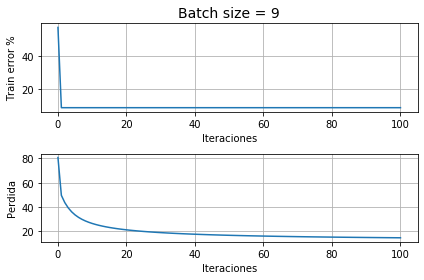

beta_hat= [-4.91055688  8.77979807 -2.17311365 -0.32696179  0.58071703  2.325793
  0.04479777  2.00969346  1.83257881  1.70586735  1.89491893  3.07499889]
Error de clasificacion= 9.09 %


CPU times: user 16min 37s, sys: 1min 5s, total: 17min 43s
Wall time: 19min 30s


In [73]:
%%time
# Método de SGD
np.random.seed(3338014)
for batch_size in range(9,10):
    
    print("*========================================================================*")
    #print("Tamaño de minilote= ",batch_size)
    beta_hat, loss, error = SGD_paralelo(x_train, y_train, max_iter=10**4)
    yhat = clasifica(x_test,beta_hat)
    titulo="Batch size = "+ str(batch_size)
    graf_loss_err(loss,error,titulo)
    print("beta_hat=", beta_hat)
    print("Error de clasificacion=",round(100*sum(abs(y_test-yhat))/len(yhat),2),"%")
    print("\n")

# Resultados del modelo logístico

- El problema de regresión logística es una extensión del problema de regresión lineal aplicada a clasificación. 

- La probabilidad de que un paciente muera a causa del virus del ébola para este modelo
se define de la siguiente forma:

$$
P\left(y=1\right)=\frac{e^{\beta^{T}x}}{1+e^{\beta^{T}x}}\label{eq:prob_y1a}
$$

ó:

$$
P\left(y=1\right)=\frac{e^{\beta_{0}+\beta_{1}x_{1}+\ldots+\beta_{p}x_{p}}}{1+e^{\beta_{0}+\beta_{1}x_{1}+\ldots+\beta_{p}x_{p}}}\label{eq:prob_y1b}
$$

- No estamos considerando el término equivalente al intercepto en el caso de regresión
lineal (i.e $\beta_{0}=0)$.
- No se afectan de forma lineal las probabilidades.
- Interpretaciones: espejar el componente lineal de la ecuación. 
- **logit**: log del cociente entre la probabilidad de morir y la probabilidad de sobrevivir al virus (ratio de
probabilidades: línea recta, dependiente del conjunto de covariables, $x$):

$$
\lambda=\log\left\{ \frac{P\left(y=1\right)}{1-P\left(y=1\right)}\right\} =\beta_{1}x_{1}+\ldots+\beta_{p}x_{p}\label{eq:param_logit}
$$


- No asume homocedasticidad: modelo dicotómico.
- La interpretación de los resultados del modelo de regresión logística: $exp(\lambda)$.
- Es el indicador de variación en el ratio de probabilidades como resultado del cambio en una unidad en la predicción.


**Resultados con métodos no estocásticos**

$$
ratio\:probs=\exp(\log\{-10.95x_{1}+18.88x_{2}-4.42x_{3}+1.14x_{4}+1.40x_{5}+4.76x_{6}-0.94x_{7}+3.006x_{8}+3.73x_{9}+4.45x_{10}+5.20x_{11}+6.38x_{12}
$$

donde $x_{1},\ldots,x_{12}$ corresponden a: cycle threshold,
temperatura, dolor de cabeza, sangrado, diarrea, vómito, presencia
de PABD, debilidad, edad hasta 22 años, edad entre 23 y 36 años, edad
entre 37 y 45 años, y edad mayor a 45 años, respectivamente.

- Se debe calcular un valor de referencia con el cual se pueda comparar. 

- Caso sin ninguna complicación de salud adicional al virus del ébola, y su edad se encuentra en un rango de 0 años a 22 años

Es decir $x_{i}=0$ para $i=3,4,5,6,7,8$ y $x_{9}=1$, por lo tanto:

$$
ratio\:probs=\exp\left(\log\left\{ -10.95x_{1}+18.88x_{2}+3.73\right\} \right)
$$

Reemplazamos en el ratio de probabilidades:

$$
ratio\:probs_{0}=\exp\left(\log\left\{ -10.95\bar{x}_{1}+18.88\bar{x}_{2}+3.73\right\} \right)=\exp\left(\log\left\{ -10.95(25.72)+18.88(37.25)+3.73\right\} \right)=425.75
$$

**Ejemplo:** 

¿Cuál es el efecto de que la persona tenga sangrado sobre la probabilidad de que la persona
muera por presencia del virus del ébola, debemos calcular el ratio
de probabilidades ahora con $x_{4}=1$ ?:

$$
ratio\:probs_{1}=\exp\left(\log\left\{ -10.95\bar{x}_{1}+18.88\bar{x}_{2}+1.14+3.73\right\} \right)=\exp\left(\log\left\{ -10.95(25.72)+18.88(37.25)+1.14+3.73\right\} \right)=426.8
$$


Ahora, si calculamos el ratio entre $ratio\:probs_{0}$ y $ratio\:probs_{1}$, tenemos:

$$
\frac{ratio\:probs_{1}}{ratio\:probs_{0}}=\frac{426.89}{425.75}=1.0026\label{eq:delt_odd}
$$

- Puesto que esta ecuación es mayor a 1, esto indica que la probabilidad
de la variable dependiente incrementa. 
- Una persona con edad de 0 años a 22 años que tiene ébola, tener sangrado, afecta positivamente su probabilidad de morir.

